In [ ]:
%pip install seaborn xgboost tensorflow scipy keras_tuner shap


   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   ---------------------------------------- 531.1/531.1 kB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --------------------------------- ------ 2.4/2.8 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 10.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   --- ------------------------------------ 2.4/30.3 MB 12.2 MB/s eta 0:00:03
   ------ --------------------------------- 5.0/30.3 MB 11.6 MB/s eta 0:00:03
   --------- ------------------------------ 7.3/30.3 MB 11.9 MB/s eta 0:00:02
   ------------- -------------------------- 10.0/30.3 MB 11.7 MB/s eta 0:00:02
   ---------------- ----------------------- 12.6/30.3 MB 11.8 MB/s eta 0:00:02
   -------------------- ------------------- 15.2/30.3 MB 11.8 MB/s eta 0:00:02
   ----------------------- ---------------- 17.6/30.3 MB 11.8 MB/s eta 0:00:02
   --

In [4]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import shap

In [5]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

print(df.columns)

Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'sequence', 'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc',
       ...
       '9_wm_pssm_K', '9_wm_pssm_M', '9_wm_pssm_F', '9_wm_pssm_P',
       '9_wm_pssm_S', '9_wm_pssm_T', '9_wm_pssm_W', '9_wm_pssm_Y',
       '9_wm_pssm_V', 'p_interface'],
      dtype='object', length=138)


In [7]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
Class 0: 57304 samples (87.96%)
Class 1: 7845 samples (12.04%)


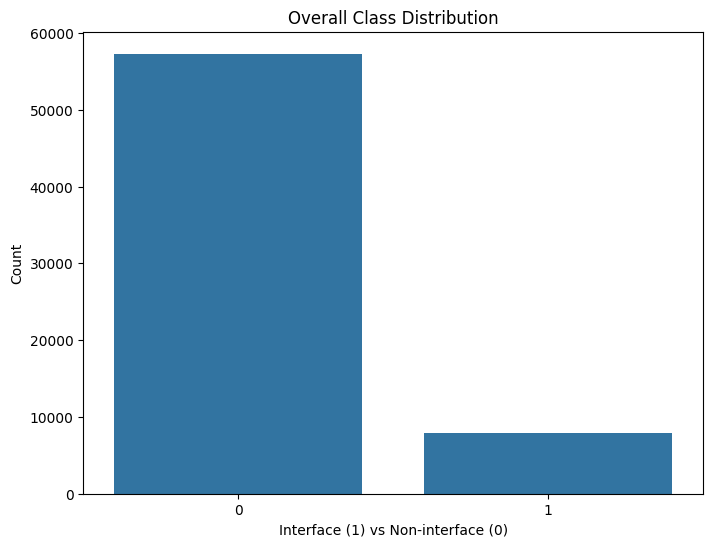

In [ ]:
######################################################## check overall class distrubution
target = "p_interface"
initial_class_counts = df[target].value_counts()
initial_class_percentages = df[target].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for cls, count in initial_class_counts.items():
    percentage = initial_class_percentages[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [10]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Total Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 80% train and 20% (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.2, random_state=42)

# Second split: Split the temporary groups into validation and test equally (5% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Total Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [11]:
####################################### calcualte class weight of train
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print(class_weights)

{np.int64(0): np.float64(0.5681916691950935), np.int64(1): np.float64(4.166136977594152)}


In [12]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 182
Unique uniprot_ids in Validation: 23
Unique uniprot_ids in Test: 23



Class Distribution:
Class 0: 46142 samples (88.00%)
Class 1: 6293 samples (12.00%)


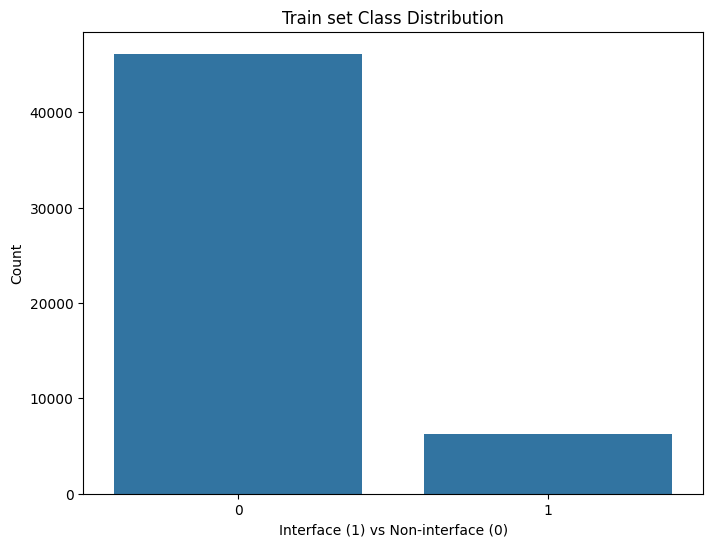

In [13]:
######################################################## check class distrubution for training set
# Check overall class distribution for the target
target = "p_interface"
initial_class_counts = train_df[target].value_counts()
initial_class_percentages = train_df[target].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for cls, count in initial_class_counts.items():
    percentage = initial_class_percentages[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_df)
plt.title("Train set Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

Threshold: 34.57692307692308
Number of proteins in group_low (<= threshold): 105
Number of proteins in group_high (> threshold): 77
Number of proteins after balancing: 137

Class Distribution:
Class 0: 33199 samples (85.77%)
Class 1: 5507 samples (14.23%)


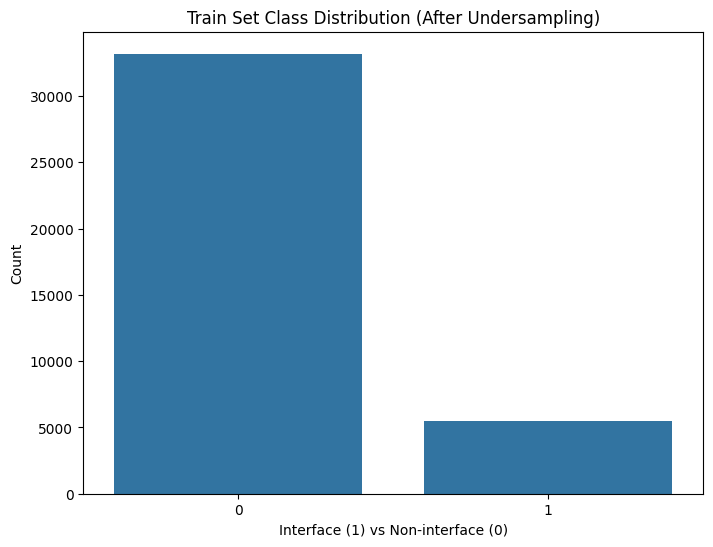

In [ ]:
######################################### undersampling
import random
#Compute the number of interface occurrences per protein in the training set.
#Since target is binary (0 or 1), summing gives the count for interface per protein.
protein_interface_counts = train_df.groupby("uniprot_id")[target].sum()

# Define mean and threshold
mean_counts = protein_interface_counts.mean()
threshold = mean_counts 

print("Threshold:", threshold)

#Group proteins based on whether their interface count is <= threshold or > threshold.
group_low = protein_interface_counts[protein_interface_counts <= threshold].index.tolist()
group_high = protein_interface_counts[protein_interface_counts > threshold].index.tolist()

print("Number of proteins in group_low (<= threshold):", len(group_low))
print("Number of proteins in group_high (> threshold):", len(group_high))

# Randomly sample proteins from group low 
# Set random seed for reproducibility
random.seed(42)

# number of proteins to sample
sample_size = 60 

# Randomly sample proteins from group_low
group_low_sampled = random.sample(group_low, min(sample_size, len(group_low)))


#Combine the selected proteins from both groups.
selected_proteins = list(group_low_sampled) + list(group_high)
print("Number of proteins after undersampling:", len(selected_proteins))

train_df_balanced = train_df[train_df['uniprot_id'].isin(selected_proteins)]

class_counts = train_df_balanced[target].value_counts()
class_percentages = train_df_balanced[target].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for cls, count in class_counts.items():
    percentage = class_percentages[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_df_balanced)
plt.title("Train Set Class Distribution (After Undersampling)")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()


In [23]:
# Define features and target for training set after undersampling
X_train_undersampled = train_df_balanced.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train_undersampled = train_df_balanced[target]

In [24]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_undersampled = scaler.fit_transform(X_train_undersampled)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [25]:
#################################################### Linear regression

# Initialize and fit the Linear Regression model
model = LogisticRegression()
model.fit(X_train_undersampled, y_train_undersampled)

#y_pred_LR = model.predict(X_test)
y_pred_LR = model.predict_proba(X_test)[:, 1]

# Convert continuous predictions to binary class labels using a threshold of 0.5
y_pred_class_LR = (y_pred_LR >= 0.5).astype(int)

# Evaluate the classifier
accuracy_LR = accuracy_score(y_test, y_pred_class_LR)
precision_LR = precision_score(y_test, y_pred_class_LR, zero_division=0)
recall_LR = recall_score(y_test, y_pred_class_LR, zero_division=0)
f1_LR = f1_score(y_test, y_pred_class_LR, zero_division=0)


Accuracy: 0.88
Precision: 0.36
Recall: 0.01
F1 Score: 0.01
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5714
           1       0.36      0.01      0.01       797

    accuracy                           0.88      6511
   macro avg       0.62      0.50      0.47      6511
weighted avg       0.82      0.88      0.82      6511



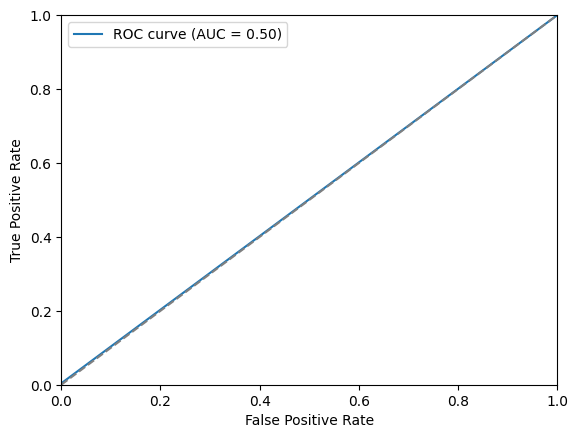

In [26]:
################################################# print results Linear regression

print(f"Accuracy: {accuracy_LR:.2f}")
print(f"Precision: {precision_LR:.2f}")
print(f"Recall: {recall_LR:.2f}")
print(f"F1 Score: {f1_LR:.2f}")

# Compute ROC curve with continuous probabilities
print(classification_report(y_test, y_pred_class_LR, zero_division=0))
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_class_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [27]:
###################################################### hyperparamtater tuning Random Forest

param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='accuracy',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Validation Accuracy (RF): 0.8303814561617842


In [ ]:
################################################# get best scores hyperparamter 
y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

In [28]:
############################################################### print score random forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

NameError: name 'accuracy_RF' is not defined

In [ ]:
############################################### hyper paramter tuning XGBoost

param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_XGB = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight=class_weights),
    param_grid_XGB, 
    scoring='accuracy',
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]


----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.8782846819682357


c:\Users\vasso\OneDrive\Υπολογιστής\Scientific Machine Learning\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
############################################### running XGBoost

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)



XGBoost Classifier Performance:
Accuracy: 0.88
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5714
           1       0.00      0.00      0.00       797

    accuracy                           0.88      6511
   macro avg       0.44      0.50      0.47      6511
weighted avg       0.77      0.88      0.82      6511



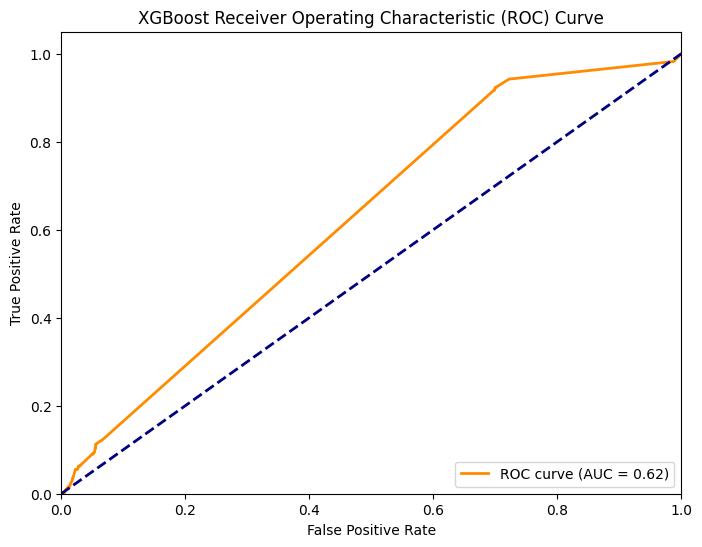

In [ ]:
############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
################################################## make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_undersampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])



c:\Users\vasso\OneDrive\Υπολογιστής\Scientific Machine Learning\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
###################################################### train model and set the class weights



history = model.fit(
    X_train_undersampled, y_train_undersampled,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)


Epoch 1/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5024 - auc: 0.5896 - loss: 0.8018 - val_accuracy: 0.4882 - val_auc: 0.6819 - val_loss: 0.7339
Epoch 2/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5179 - auc: 0.6788 - loss: 0.6854 - val_accuracy: 0.5207 - val_auc: 0.7108 - val_loss: 0.6976
Epoch 3/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5473 - auc: 0.7052 - loss: 0.6653 - val_accuracy: 0.5322 - val_auc: 0.7092 - val_loss: 0.6896
Epoch 4/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5496 - auc: 0.7170 - loss: 0.6596 - val_accuracy: 0.5260 - val_auc: 0.7032 - val_loss: 0.7108
Epoch 5/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5623 - auc: 0.7281 - loss: 0.6442 - val_accuracy: 0.5583 - val_auc: 0.7179 - val_loss: 0.6838
Epoch 6/50
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5691 - auc: 0.7318 - loss: 0.6436 - val_accuracy: 0.5449 - val_auc: 0.7118 - val_loss: 0.6648
Epoch 7/50
1210/1210 ━━━━━━━

In [31]:
####################################################### caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# 2. Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)



204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Accuracy: 0.57
Precision: 0.17
Recall: 0.68
F1 Score: 0.28

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      5714
           1       0.17      0.68      0.28       797

    accuracy                           0.57      6511
   macro avg       0.55      0.62      0.49      6511
weighted avg       0.83      0.57      0.64      6511



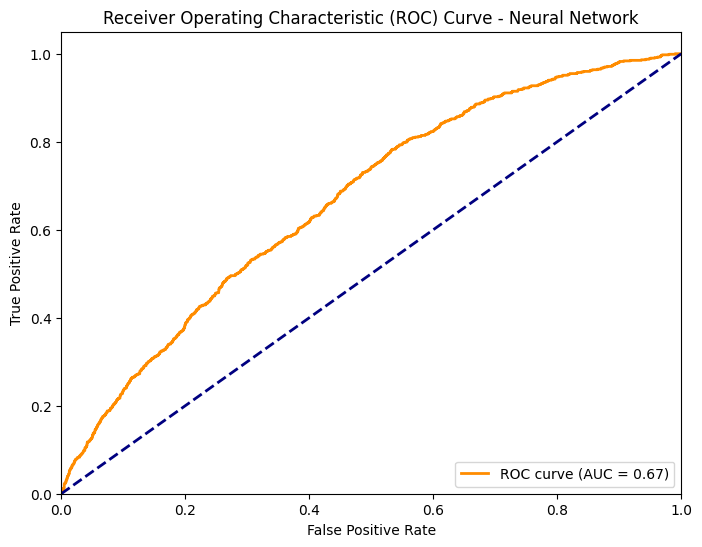

In [32]:
######################################################## print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# 5. Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

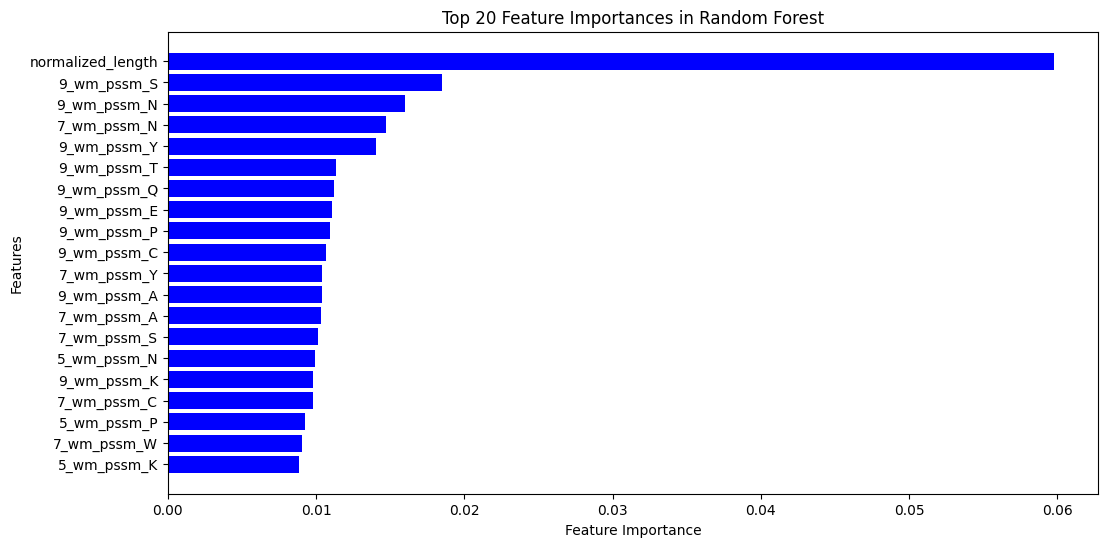

In [33]:
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names = train_df_test.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_train_names = pd.DataFrame(X_train, columns=feature_names)



# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()
